In [1]:
%matplotlib inline

import math

import numpy as np
import matplotlib.pyplot as plt

# Carbon Impulse Response Function (i.e. the baseline curve)

This section models two Impulse Reponse Functions (IRFs). An IRF represents the time-dependent fraction of an  emission pulse remaining in the atmosphere at time t. It is usually approximated by a sum of exponentials:

$ IRF_x(t) = a_{x,0} + \sum_{i=1}^{3} a_{x,i} * e^{-t / tau_i} $

You can read more about IRFs here: https://www.ipcc.ch/site/assets/uploads/2018/07/WGI_AR5.Chap_.8_SM.pdf 


The $a$ and $tau$ parameters for CO2 can be taken from literature: 

- Joos, F., Roth, R., Fuglestvedt, J. S., Peters, G. P., Enting, I. G., von Bloh, W., Brovkin, V., Burke, E. J., Eby, M., Edwards, N. R., Friedrich, T., Frölicher, T. L., Halloran, P. R., Holden, P. B., Jones, C., Kleinen, T., Mackenzie, F. T., Matsumoto, K., Meinshausen, M., Plattner, G.-K., Reisinger, A., Segschneider, J., Shaffer, G., Steinacher, M., Strassmann, K., Tanaka, K., Timmermann, A., and Weaver, A. J.: Carbon dioxide and climate impulse response functions for the computation of greenhouse gas metrics: a multi-model analysis, Atmos. Chem. Phys., 13, 2793–2825, https://doi.org/10.5194/acp-13-2793-2013, 2013.


- Forster, P., V. Ramaswamy, P. Artaxo, T. Berntsen, R. Betts, D.W. Fahey, J. Haywood, J. Lean, D.C. Lowe, G. Myhre, J. Nganga, R. Prinn, G. Raga, M. Schulz and R. Van Dorland, 2007: Changes in Atmospheric Constituents and in Radiative Forcing. In: Climate Change 2007: The Physical Science Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt, M.Tignor and H.L. Miller (eds.)]: https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter2-1.pdf (pg. 213)


- IPCC: Special Report on Land Use, Land‐Use Change, and Forestry, Section 2.3.6.3, 2000, https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74 and footnote https://archive.ipcc.ch/ipccreports/sres/land_use/fn3.htm#4


In [2]:
def get_irf_curve(curve_name):
    
    if curve_name == 'joos_2013':
        # parameters from Joos et al., 2013 (Table 5) 
        # https://doi.org/10.5194/acp-13-2793-2013
        a = [0.2173, 0.2240, 0.2824, 0.2763]
        tau = [0, 394.4, 36.54, 4.304]
        t_horizon = np.arange(1001)
        
    elif curve_name == 'ipcc_2007':
        # parameters from IPCC AR4 2007 (Chapter 2, page 213)
        # https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter2-1.pdf
        a = [0.217, 0.259, 0.338, 0.186]
        tau = [0, 172.9, 18.51, 1.186]
        t_horizon = np.arange(1001)
        
    elif curve_name == 'ipcc_2000':
        # parameters from IPCC Land Use, Land-Use Change and Forestry Special Report 2000 (Chapter 2.3.6.3, Footnote 4) 
        # https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74
        a = [0.175602, 0.137467, 0.18576, 0.242302, 0.258868]
        tau = [0, 421.093, 70.5965, 21.42165, 3.41537]
        t_horizon = np.arange(1001)
        
    else:
        raise ValueError('No IRF parameters by the name \'' + curve_name + '\'.')  

    irf_curve = [a[0]] * len(t_horizon)
    for t in t_horizon:
        for i in np.arange(1,len(a)):
            irf_curve[t] =  irf_curve[t] + (a[i] * np.exp(-t/tau[i]))
    return irf_curve

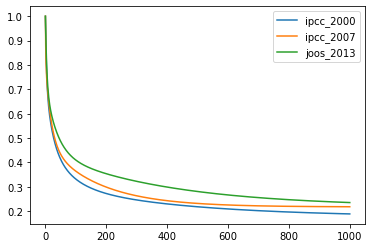

In [3]:
ipcc_2000 = get_irf_curve('ipcc_2000')
ipcc_2007 = get_irf_curve('ipcc_2007')
joos_2013 = get_irf_curve('joos_2013')
plt.plot(ipcc_2000, label='ipcc_2000')
plt.plot(ipcc_2007, label='ipcc_2007')
plt.plot(joos_2013, label='joos_2013')
plt.legend()

# Ton-year accounting methods

Some terms for interpreting the three ton-year accounting methods implemented below

- *Baseline:* the curve atmospheric state-of affairs that is assumed to be the counterfaction to a project scenario
- *Baseline atmospheric impact:* the integral of the baseline curve
- *Scenario:* the curve representing what happens because of an intervention (could be representing carbon in a stock or carbon in the atmosphere depending on the method)
- *Benefit:* the reduction in atmospheric impact as a result of the scenario intervention 
- *Equivalence factor:* the ratio between the benefit and the atmospheric impact of a single tCO2 released at t=0 under shared assumptions


Some helper functions:

In [6]:
def get_discounted_curve(discount_rate, curve): 
    return np.array([x/math.pow(1+discount_rate, i) for i,x in enumerate(curve)])

In [7]:
def print_benefit_report(method_output, plot):
    print()
    print('Discount rate: ' + str(round(method_output['parameters']['discount_rate']*100,1)) + '%')
    print('Delay: ' + str(method_output['parameters']['delay']) + ' year(s)')
    print('Baseline atmospheric cost: ' + str(round(method_output['baseline_atm_cost'],2)) + ' ton-years')
    print('Benefit from 1tCO2 with delay: ' + str(round(method_output['benefit'],2)) + ' ton-years')
    print('Number needed: ' + str(round(method_output['num_for_equivalence'],1)))
    print()
    if plot: 
        plot = plt.plot(method_output['baseline'], label="baseline")
        plot = plt.plot(method_output['scenario'], label="scenario")
        plot = plt.legend()

And a function implementing the three ton-year accounting set-ups:

In [8]:
def calculate_tonyears(method, baseline, time_horizon, delay, discount_rate):
    
    if delay < 0: 
        raise ValueError('Delay cannot be negative.')
    if time_horizon <= 0:
        raise ValueError('Time horizon must be greater than zero.')
    if len(baseline) < time_horizon:
        raise ValueError('Method cannot analyze over a time horizon that is longer than the baseline scenario (i.e. the length of the baseline array).')
    if method not in ['mc', 'ipcc', 'lashof']:
        raise ValueError('No ton-year accounting method called \'' + method + '\'. Options include: Moura-Costa (\'mc\'), Lashof (\'lashof\'), and IPCC (\'ipcc\').')
    
    
    # All methods calculate the baseline cost of emitting 1tCO2 at t=0 as the 
    # atmospheric ton-years incurred over the period 0<=t<=time_horizon. 
    time_horizon_timesteps = time_horizon + 1
    baseline = baseline[:time_horizon_timesteps]
    baseline_discounted = get_discounted_curve(discount_rate, baseline)
    baseline_atm_cost = np.trapz(baseline_discounted)

    if method == 'mc':
        # The Moura-Costa method calculates the ton-year benefit of a delayed emission
        # as the ton-years of carbon storage outside of the atmosphere over the period
        # 0<=t<=delay. Moura-Costa ignores the atmospheric impact of post-storage re-emission.  
        delay_timesteps = delay + 1
        scenario = [-1]*(delay_timesteps) + [0]*(len(baseline) - delay_timesteps)
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = -np.trapz(scenario[:delay_timesteps])
        
    elif method == 'ipcc':
        # The IPCC method calculates calculates the ton-year benefit of an emission at t=delay
        # as the difference between the baseline atmospheric cost and the scenario atmospheric
        # cost, which is calculated over the period delay<=t<=time_horizon. 
        scenario = [0]*delay + baseline
        scenario = scenario[:time_horizon_timesteps]
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = baseline_atm_cost - np.trapz(scenario[delay:])
        
    elif method == 'lashof':
        # The Lashof method calculates the ton-year benefit of an emission at t=delay
        # as the atmospheric cost that no longer occurs within the time horizon. The 
        # benefit calculation is thus focused the period time_horizon<=t<=(time_horizon+delay). 
        scenario = [0]*delay + baseline
        scenario = get_discounted_curve(discount_rate, scenario)
        benefit = np.trapz(scenario[time_horizon:])  
    
    return {'parameters': {'method': method,
                           'time_horizon': time_horizon,
                           'delay': delay,
                           'discount_rate': discount_rate}, 
            'baseline': baseline_discounted,
            'scenario': scenario,
            'baseline_atm_cost': baseline_atm_cost,
            'benefit': benefit,
            'num_for_equivalence': baseline_atm_cost/benefit}

### Moura-Costa method

Method referenced IPCC Special report (2000) with outputs to check against: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

Method also described in Moura Costa and Wilson, 2000: https://oxfordclimatepolicy.org/sites/default/files/10.1023%252FA_1009697625521.pdf


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 46.0 ton-years
Number needed: 1.0



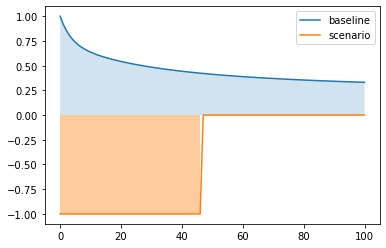

In [9]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

mm = calculate_tonyears('mc', baseline, time_horizon, delay, discount_rate)
print_benefit_report(mm, plot=True)

t = np.arange(mm['parameters']['time_horizon'] + 1)
plot = plt.fill_between(t, mm['baseline'], alpha = 0.2)
plot = plt.fill_between(t[:len(mm['scenario'])], mm['scenario'], where=(np.array(mm['scenario'])<0), alpha = 0.4)

Baseline = 1 tCO2 atmospheric carbon released at t=0 <br/>
Scenario = 1 tCO2 stored outside of the atmosphere for delay<br/>
Baseline atmospheric cost = (blue area) <br/>
Benefit = (orange area) <br/>
Number needed = how many orange areas are equivalent to the blue area? <br/>
** Assumes 0% re-emission ** <br/>

### IPCC method 

Method described IPCC Special report, 2000: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

Conceptually distinct but numerically identical to Lashof method when discount_rate = 0


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 16.64 ton-years
Number needed: 2.8



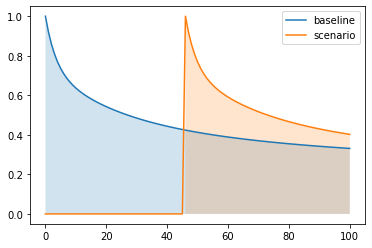

In [10]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

i = calculate_tonyears('ipcc', baseline, time_horizon, delay, discount_rate)
print_benefit_report(i, plot=True)

t = np.arange(i['parameters']['time_horizon'] + 1)
plot = plt.fill_between(t, i['baseline'], alpha = 0.2)
plot = plt.fill_between(t, i['scenario'], where=(t>=i['parameters']['delay']), alpha=0.2) 

Baseline = 1 tCO2 released into atmospheric at t=0 <br/>
Scenario = 1 tCO2 released into atomosphere with delay <br/>
Baseline atmospheric cost = (blue area) <br/>
Benefit = (blue area) - (orange area) <br/>
Number needed = how would you need to scale the "benefit" to equal to the blue area? <br/>
** Assumes 100% re-emission **

### Lashof method

Method referenced IPCC Special report, 2000: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

And described in Fearnside, Lashof & Moura-Costa, 2000: https://link.springer.com/article/10.1023%2FA%3A1009625122628

Conceptually distinct but numerically identical to IPCC method when discount_rate = 0


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 16.64 ton-years
Number needed: 2.8



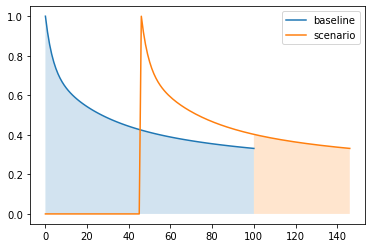

In [11]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

l = calculate_tonyears('lashof', baseline, time_horizon, delay, discount_rate)
print_benefit_report(l, plot=True)

t = np.arange(l['parameters']['time_horizon'] + l['parameters']['delay']+ 1)
plot = plt.fill_between(t[:len(l['baseline'])], l['baseline'], alpha = 0.2)
plot = plt.fill_between(t, l['scenario'], where=(t>=l['parameters']['time_horizon']), alpha = 0.2)

Baseline = 1 tCO2 released into atmospheric at t=0 <br/>
Scenario = 1 tCO2 released into atomosphere with delay <br/>
Baseline atmospheric cost = (blue area)
Benefit = (orange area) = atmospheric cost no longer occuring w/in the time horizon <br/>
Number needed = how many orange areas would you need to equal the blue area?<br/>
** Assumes 100% re-emission **

# Methods x Delay

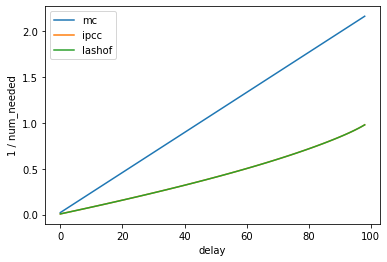

In [13]:
time_horizon = 100
baseline = ipcc_2000
#delay = 1
discount_rate = 0.0

for method in ['mc', 'ipcc', 'lashof']:
    num_needed = []
    for delay in np.arange(1,100):
        num_needed.append(1/calculate_tonyears(method, baseline, time_horizon, delay, discount_rate)['num_for_equivalence'])
    plt.plot(num_needed, label=method)

plt.xlabel('delay')
plt.ylabel('1 / num_needed')
plt.legend()

# Methods x Time Horizon

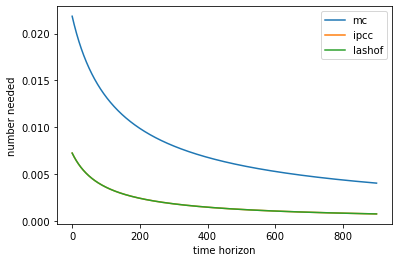

In [14]:
#time_horizon = 100
baseline = ipcc_2000
delay = 1
discount_rate = 0.0

for method in ['mc', 'ipcc', 'lashof']:
    num_needed = []
    for time_horizon in np.arange(100,1000):
        num_needed.append(1/calculate_tonyears(method, baseline, time_horizon, delay, discount_rate)['num_for_equivalence'])
    plt.plot(num_needed,label=method)

plt.xlabel('time horizon')
plt.ylabel('number needed')
plt.legend()

# Methods x Discounting

Lashof excluded in the graph below as it is highly sensitive to discounting and blows up as discount rate increases

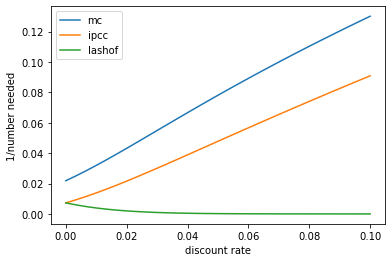

In [15]:
time_horizon = 100
baseline = ipcc_2000
delay = 1
#discount_rate = 0.0

d = np.linspace(0, 0.1, 30)
for method in ['mc', 'ipcc', 'lashof']:
    num_needed = []
    for discount_rate in d:
        num_needed.append(1/calculate_tonyears(method, baseline, time_horizon,delay, discount_rate)['num_for_equivalence'])
    plt.plot(d, num_needed,label=method)

plt.xlabel('discount rate')
plt.ylabel('1/number needed')
plt.legend()


### Cost sensitivity

Imagine a carbon credit is $10/tCO2, where a 'tCO2' is a handful of ton-years packaged up according to the a ton-year accounting methodology. As a baseline, let imagine the methodology applied results in a favorable (i.e. low) ratio of ton-years needed to be 'equivalent' to the impacts of an emitted tCO2. 

In [21]:
time_horizon = 100
baseline = ipcc_2000
delay = 1
discount_rate = 0.03

cost_per_ton = 10

x = calculate_tonyears('mc', baseline, time_horizon, delay, discount_rate)
ton_year_cost = cost_per_ton/x['baseline_atm_cost']
print('Cost per ton-year: $' + str(round(ton_year_cost,2)))
print('Cost of permanent ton: $' + str(round(ton_year_cost * x['num_for_equivalence'])))

Cost per ton-year: $0.56
Cost of permanent ton: $10


If the cost/ton-year reflects a true cost of taking an action today, we can ask how the cost of a buying a 'equivalent tCO2' via ton-years today changes as we change the method or parameters:

In [22]:
time_horizon = 1000
baseline = joos_2013
delay = 1
discount_rate = 0.00

y = calculate_tonyears('ipcc', baseline, time_horizon, delay, discount_rate)
print_benefit_report(y, False)
print('Cost per ton-year: $' + str(round(ton_year_cost,2)))
print('Cost of permanent ton: $' + str(round(ton_year_cost * ncx['num_for_equivalence'],2)))


Discount rate: 0.0%
Delay: 1 year(s)
Baseline atmospheric cost: 310.16 ton-years
Benefit from 1tCO2 with delay: 0.24 ton-years
Number needed: 1319.4

Cost per ton-year: $0.56
Cost of permanent ton: $735.31
